# Effect Classification

In [1]:
import torch
from torch import nn
import torchaudio
import os
import numpy as np
import matplotlib.pyplot as plt

### Load dataset

In [2]:
from src.gtfxdataset import GtFxDataset

AUDIO_DIR = "_assets/DATASET/GT-FX-ALL/"
ANNOTATIONS_FILE = os.path.join(AUDIO_DIR, "annotation.csv")

SAMPLE_RATE = 22050
NUM_SAMPLES = 22050*3

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using device {device}")

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=1050,
    n_mels=64,
    # power=2
)

spectrogram = torchaudio.transforms.Spectrogram(
    power=2,
    n_fft=127,
    win_length= 127,
    hop_length= 1040,
    normalized=True
)

mfcc = torchaudio.transforms.MFCC(
    sample_rate = SAMPLE_RATE, 
    n_mfcc = 64,
    melkwargs = {
        "n_fft": 1024,
        "hop_length": 1030,
        "n_mels": 64,
        "center": False})

fxData = GtFxDataset(ANNOTATIONS_FILE,
                        AUDIO_DIR,
                        mfcc,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

signal, _, _, _, _ = fxData[0]
print(f"There are {len(fxData)} samples in the dataset.")
print(f"Shape of signal: {signal.shape}")
    

Using device cpu
There are 22506 samples in the dataset.
Shape of signal: torch.Size([1, 64, 64])


#### Split dataset into train and test sets

In [3]:
from src.classifier import train

BATCH_SIZE = 128

split_ratio = [0.8, 0.1, 0.1]
train_set, test_set, val_set = torch.utils.data.random_split(fxData, lengths=split_ratio)

train_dataloader = train.create_data_loader(train_set, BATCH_SIZE)
test_dataloader = train.create_data_loader(test_set, BATCH_SIZE)
val_dataloader = train.create_data_loader(val_set, BATCH_SIZE)


#### Model training

In [4]:
from src.classifier import model

LEARNING_RATE = 0.001
EPOCHS = 10

WEIGHTS_DIR = "_weights/"
WEIGHTS_FILE = os.path.join(WEIGHTS_DIR, "c55_classify.pth")

if not os.path.exists('%s' % WEIGHTS_DIR):
    os.makedirs('%s' % WEIGHTS_DIR)

# construct model and assign it to device
cnn = model.Classifier().to(device)

# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train model
train.train(cnn,
            train_dataloader,
            test_dataloader,
            loss_fn,
            optimiser,
            device,
            EPOCHS)

# save model
torch.save(cnn.state_dict(), WEIGHTS_FILE)
print("Trained feed forward net saved at %s" %(WEIGHTS_FILE))

Epoch 1
loss: 3.733738  [  0/18048]
loss: 2.399776  [2560/18048]
loss: 1.689452  [5120/18048]
loss: 1.626127  [7680/18048]
loss: 1.345074  [10240/18048]
loss: 1.055854  [12800/18048]
loss: 1.187358  [15360/18048]
loss: 1.203625  [11900/11985]
distortion: Accuracy: 98.3%, avg loss: 0.043938
chorus: Accuracy: 88.1%, avg loss: 0.312710
tremolo: Accuracy: 68.0%, avg loss: 0.607695
delay: Accuracy: 92.1%, avg loss: 0.174432
reverb: Accuracy: 97.2%, avg loss: 0.079231
Total: avg loss: 1.218005

---------------------------
Epoch 2
loss: 1.165959  [  0/18048]
loss: 0.862200  [2560/18048]
loss: 0.931679  [5120/18048]
loss: 0.875389  [7680/18048]
loss: 0.921952  [10240/18048]
loss: 0.770408  [12800/18048]
loss: 0.704023  [15360/18048]
loss: 0.713431  [11900/11985]
distortion: Accuracy: 99.9%, avg loss: 0.007461
chorus: Accuracy: 89.3%, avg loss: 0.245978
tremolo: Accuracy: 82.6%, avg loss: 0.346881
delay: Accuracy: 94.6%, avg loss: 0.125651
reverb: Accuracy: 99.2%, avg loss: 0.030573
Total: avg 

#### Evaluation

distortion: Accuracy: 99.6%, avg loss: 0.014678
chorus: Accuracy: 94.7%, avg loss: 0.136538
tremolo: Accuracy: 92.7%, avg loss: 0.171951
delay: Accuracy: 92.7%, avg loss: 0.160553
reverb: Accuracy: 99.6%, avg loss: 0.009829
Total: avg loss: 0.493550

[[ 559    9]
 [   0 1682]]


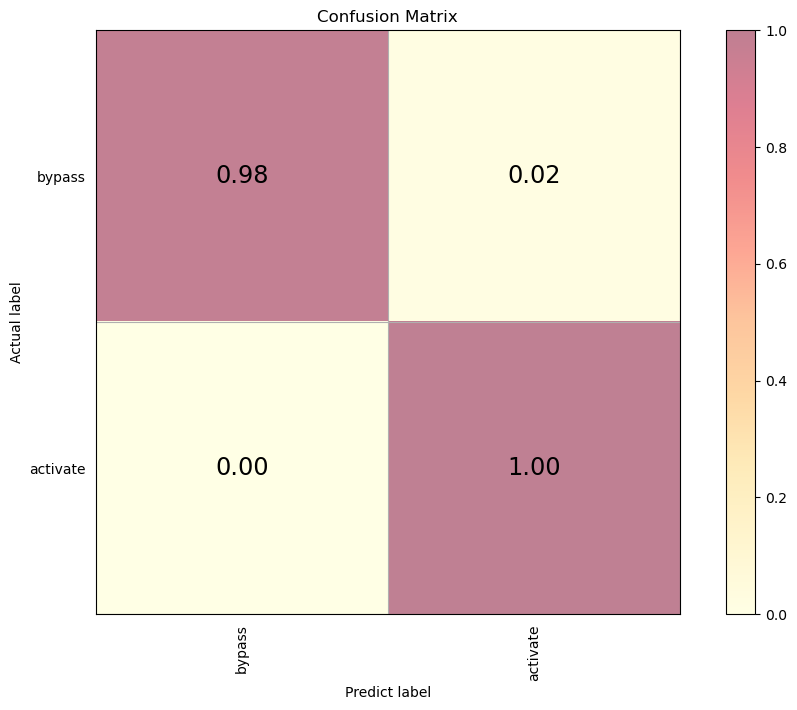

[[ 438  118]
 [   1 1693]]


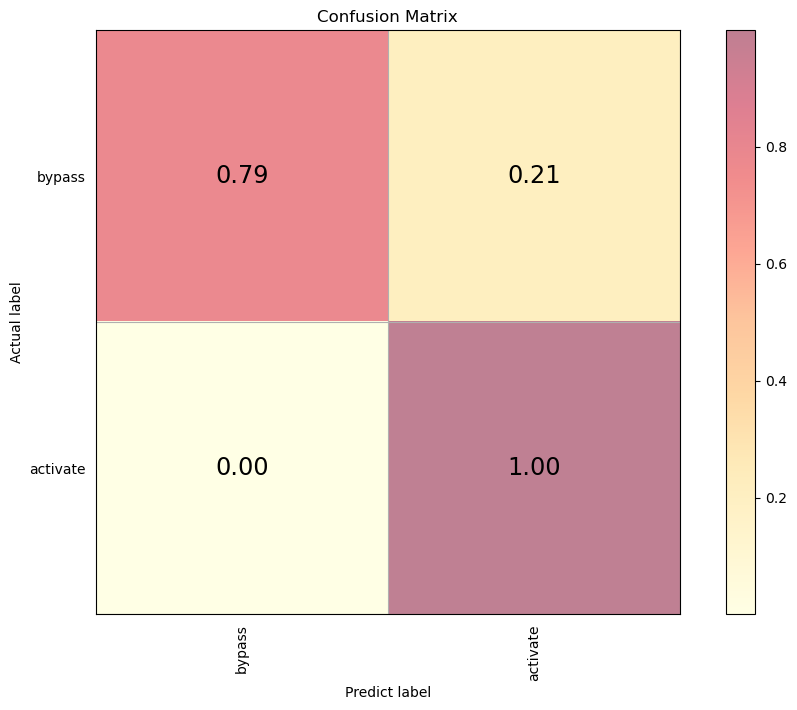

[[ 564   22]
 [ 143 1521]]


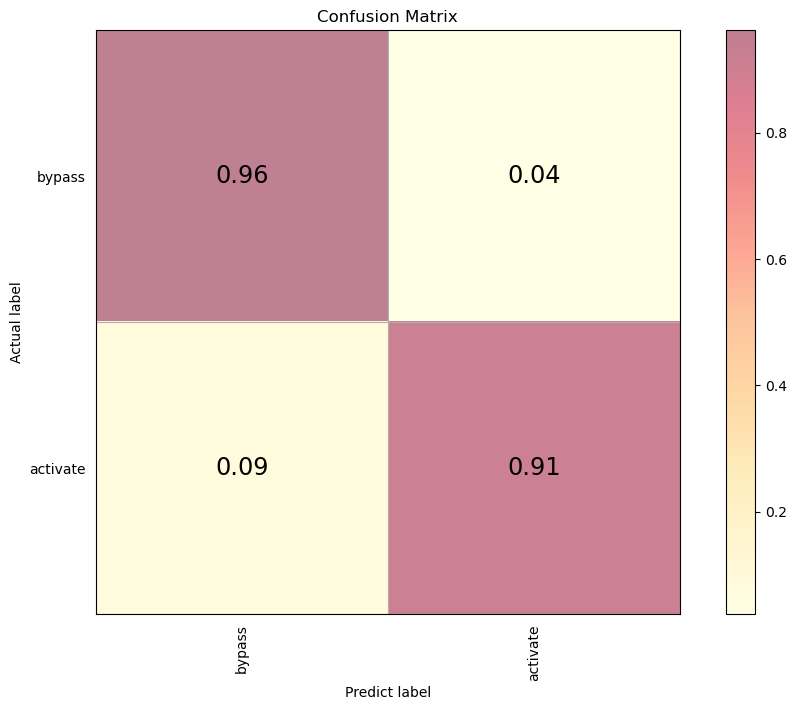

[[ 574    0]
 [ 165 1511]]


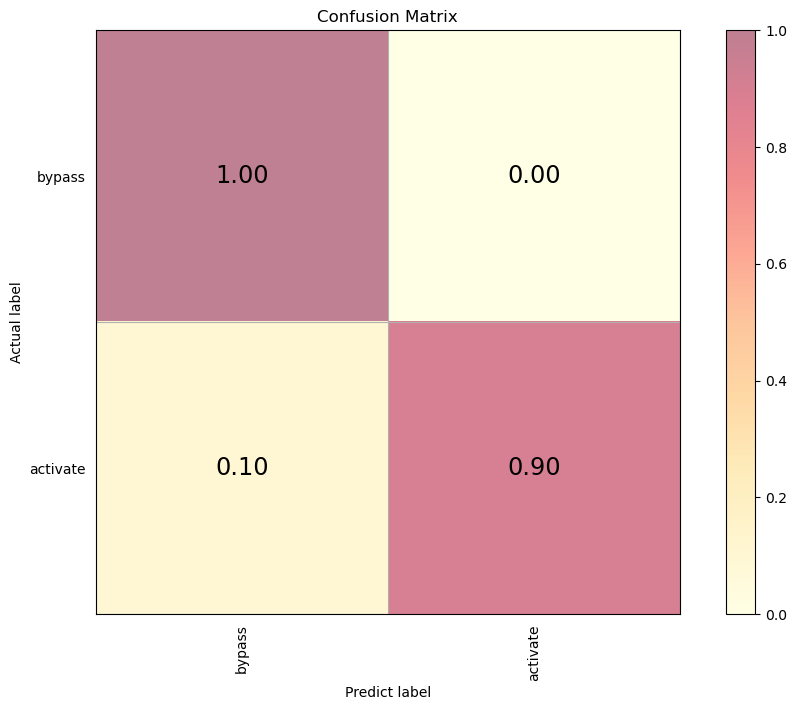

[[ 554    8]
 [   1 1687]]


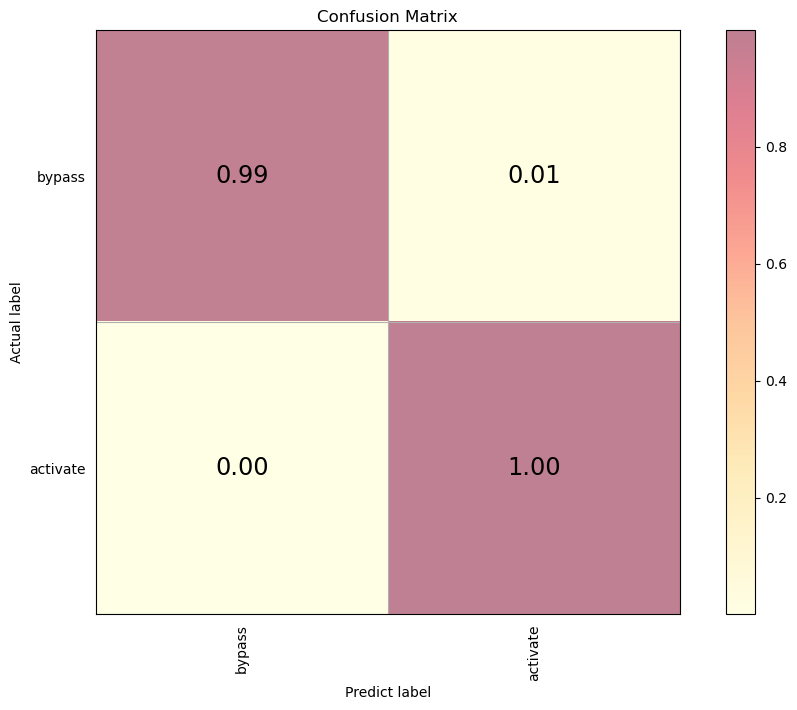

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
from src.util import plot_confusion_matrix

labels_ID = ['bypass', 'activate']

cnn = model.Classifier().to(device)

state_dict = torch.load(WEIGHTS_FILE)
cnn.load_state_dict(state_dict)

log = train.test(cnn, val_dataloader, device, mode="multi")

for i in range(5):
    expected = []
    predicted = []
    for index, data in enumerate(log[i]):
        predicted.append(data[1])
        expected.append(data[2])
    mat_con = confusion_matrix(y_true=expected, y_pred=predicted)
    print(mat_con)
    plot_confusion_matrix(mat_con, title='Confusion Matrix', classes=labels_ID)
